In [ ]:
# Install scanpy if not installed
!pip install scanpy


In [ ]:
!pip install python-igraph


In [ ]:
!pip install leidenalg


Initial dataset info:
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\neighbors\__init__.py:577: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


After preprocessing, dataset shape: (2700, 2000)

--- Baseline Clustering Metrics (Before DR) ---
Silhouette Score: 0.0134
Calinski-Harabasz Index: 20.3894
Davies-Bouldin Index: 6.4979


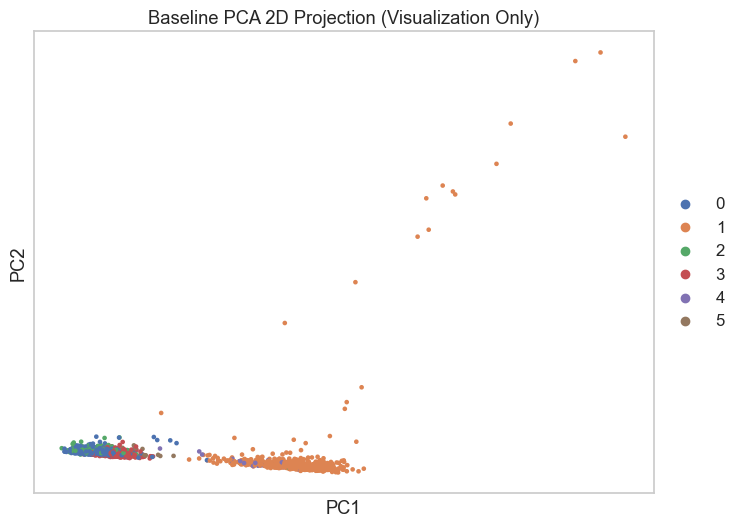


--- Linear DR (PCA) Clustering Metrics ---
Silhouette Score: 0.1809
Calinski-Harabasz Index: 176.0459
Davies-Bouldin Index: 1.7785


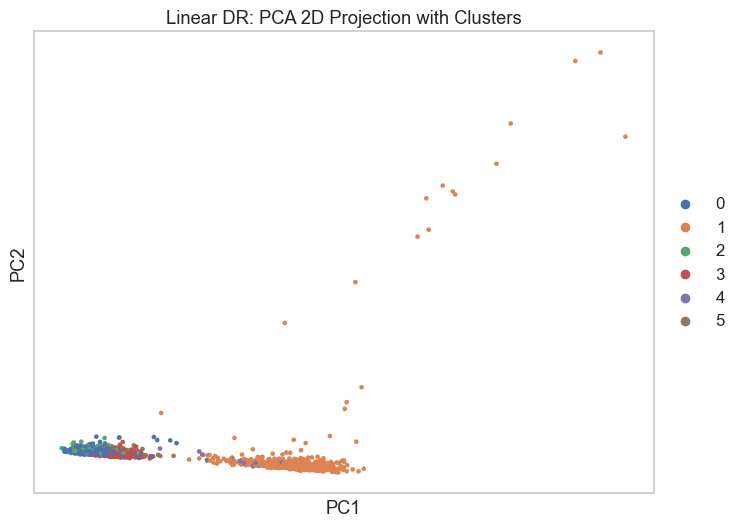


--- Nonlinear DR (UMAP) Clustering Metrics ---
Silhouette Score: 0.4660
Calinski-Harabasz Index: 6587.0986
Davies-Bouldin Index: 0.5867


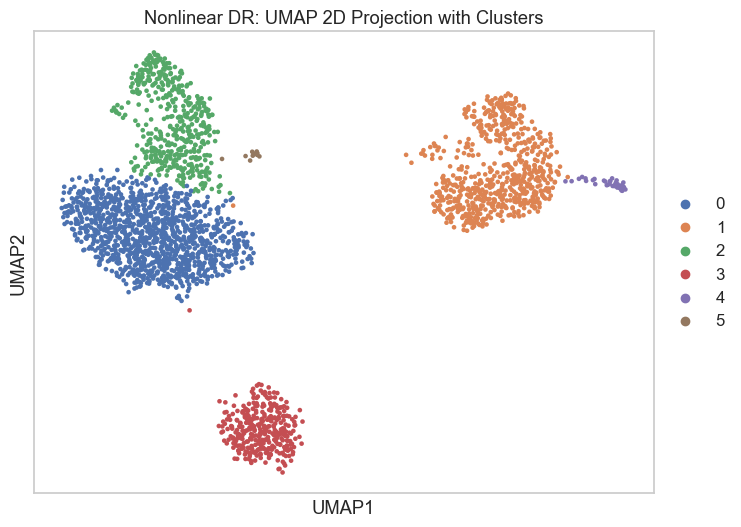

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Nonlinear DR (Autoencoder) Clustering Metrics ---
Silhouette Score: 0.1802
Calinski-Harabasz Index: 227.3192
Davies-Bouldin Index: 2.1553


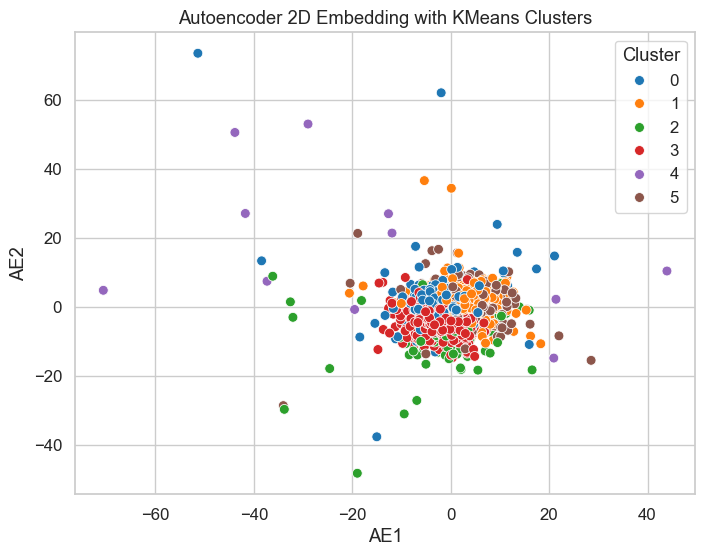

In [6]:
# ================= PBMC 3k Full Pipeline (Corrected Baseline) =================
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf
import numpy as np

# ------------------------- Setup -------------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8,6)
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# ------------------------- 1) Load Dataset -------------------------
adata = sc.datasets.pbmc3k()
print("Initial dataset info:")
print(adata)  # Cells x Genes

# ------------------------- 2) Preprocessing -------------------------
# Filter out low-quality cells and rare genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Normalize counts and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

# Scale data
sc.pp.scale(adata)
print("After preprocessing, dataset shape:", adata.X.shape)

# ------------------------- 3) Baseline Clustering (Before DR) -------------------------
# Build neighbors graph on raw HVG data (no PCA)
sc.pp.neighbors(adata, n_neighbors=15, use_rep=None)

# Leiden clustering
sc.tl.leiden(adata, resolution=0.5)
labels_baseline = adata.obs['leiden'].astype(int)

# Evaluate clustering metrics
X_baseline = adata.X
sil_baseline = silhouette_score(X_baseline, labels_baseline)
ch_baseline = calinski_harabasz_score(X_baseline, labels_baseline)
db_baseline = davies_bouldin_score(X_baseline, labels_baseline)

print("\n--- Baseline Clustering Metrics (Before DR) ---")
print(f"Silhouette Score: {sil_baseline:.4f}")
print(f"Calinski-Harabasz Index: {ch_baseline:.4f}")
print(f"Davies-Bouldin Index: {db_baseline:.4f}")

# Optional visualization (first 2 PCs for interpretability)
sc.tl.pca(adata, n_comps=2, svd_solver='arpack')
sc.pl.pca_scatter(adata, color='leiden', title="Baseline PCA 2D Projection (Visualization Only)")

# ------------------------- 4) Linear DR: PCA -------------------------
# Compute PCA embeddings (50 PCs)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

# Build neighbors graph on PCA embeddings
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

# Leiden clustering on PCA embeddings
sc.tl.leiden(adata, resolution=0.5)
labels_pca = adata.obs['leiden'].astype(int)

# Evaluate metrics
X_pca = adata.obsm['X_pca'][:, :50]
sil_pca = silhouette_score(X_pca, labels_pca)
ch_pca = calinski_harabasz_score(X_pca, labels_pca)
db_pca = davies_bouldin_score(X_pca, labels_pca)

print("\n--- Linear DR (PCA) Clustering Metrics ---")
print(f"Silhouette Score: {sil_pca:.4f}")
print(f"Calinski-Harabasz Index: {ch_pca:.4f}")
print(f"Davies-Bouldin Index: {db_pca:.4f}")

# Visualize PCA 2D
sc.pl.pca_scatter(adata, color='leiden', title="Linear DR: PCA 2D Projection with Clusters")

# ------------------------- 5) Nonlinear DR: UMAP -------------------------
# Build neighbors graph for UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

# Compute UMAP embedding
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)
labels_umap = adata.obs['leiden'].astype(int)

# Evaluate UMAP embeddings
X_umap = adata.obsm['X_umap']
sil_umap = silhouette_score(X_umap, labels_umap)
ch_umap = calinski_harabasz_score(X_umap, labels_umap)
db_umap = davies_bouldin_score(X_umap, labels_umap)

print("\n--- Nonlinear DR (UMAP) Clustering Metrics ---")
print(f"Silhouette Score: {sil_umap:.4f}")
print(f"Calinski-Harabasz Index: {ch_umap:.4f}")
print(f"Davies-Bouldin Index: {db_umap:.4f}")

# Visualize UMAP 2D
sc.pl.umap(adata, color='leiden', title="Nonlinear DR: UMAP 2D Projection with Clusters")

# ------------------------- 6) Nonlinear DR: Autoencoder -------------------------
tf.keras.backend.clear_session()

input_dim = adata.X.shape[1]
bottleneck_size = 20  # experiment with 10, 20, 50

# Build Autoencoder
inp = layers.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(inp)
bottleneck = layers.Dense(bottleneck_size, activation='linear', name='bottleneck')(x)
x = layers.Dense(128, activation='relu')(bottleneck)
out = layers.Dense(input_dim, activation='linear')(x)

ae = models.Model(inp, out)
encoder = models.Model(inp, bottleneck)
ae.compile(optimizer=optimizers.Adam(1e-3), loss='mse')

# Train Autoencoder
history = ae.fit(adata.X, adata.X, epochs=50, batch_size=64, validation_split=0.1, verbose=0)

# Extract embeddings
X_ae = encoder.predict(adata.X)

# KMeans clustering on AE embeddings
n_clusters = len(np.unique(labels_baseline))
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
labels_ae = kmeans.fit_predict(X_ae)

# Evaluate metrics
sil_ae = silhouette_score(X_ae, labels_ae)
ch_ae = calinski_harabasz_score(X_ae, labels_ae)
db_ae = davies_bouldin_score(X_ae, labels_ae)

print("\n--- Nonlinear DR (Autoencoder) Clustering Metrics ---")
print(f"Silhouette Score: {sil_ae:.4f}")
print(f"Calinski-Harabasz Index: {ch_ae:.4f}")
print(f"Davies-Bouldin Index: {db_ae:.4f}")

# Visualize Autoencoder 2D embeddings
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_ae[:,0], y=X_ae[:,1], hue=labels_ae, palette='tab10', s=50)
plt.title("Autoencoder 2D Embedding with KMeans Clusters")
plt.xlabel("AE1")
plt.ylabel("AE2")
plt.legend(title="Cluster")
plt.show()



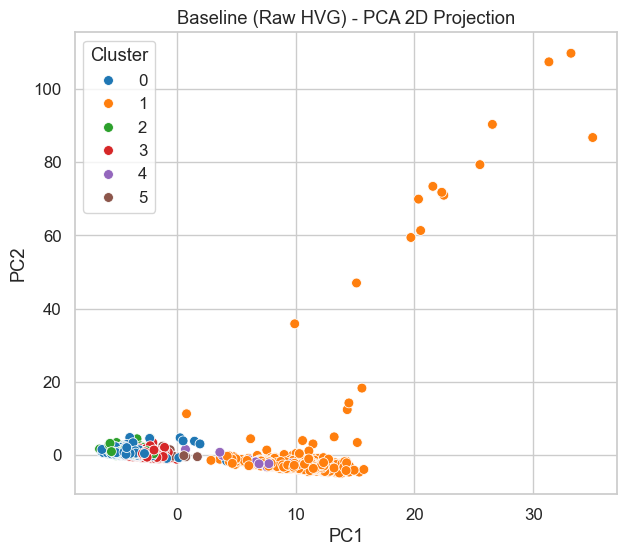

Total variance retained in 50 PCs: 3.64%


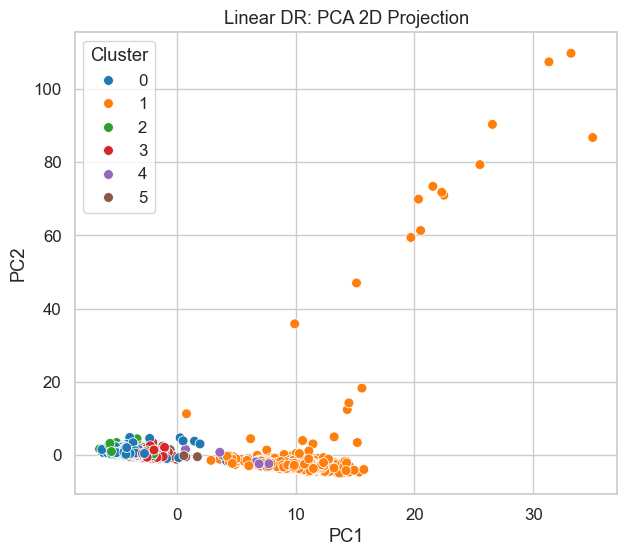

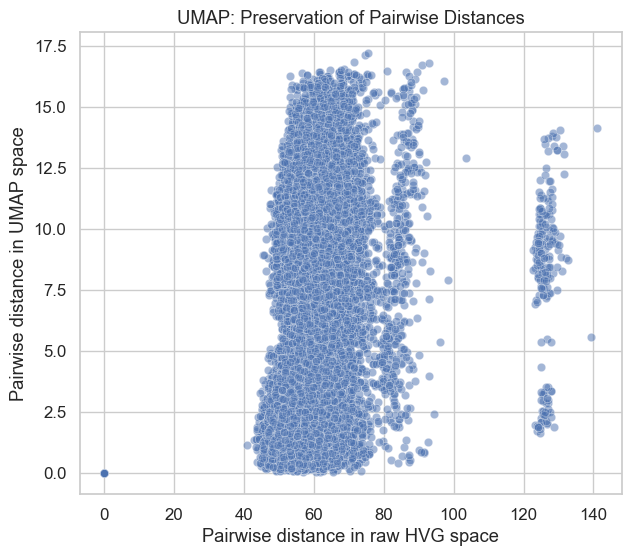

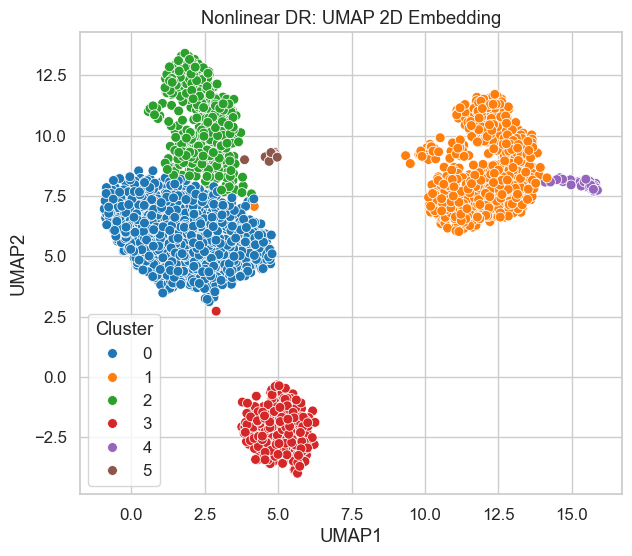

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean squared reconstruction error (Autoencoder): 0.84742


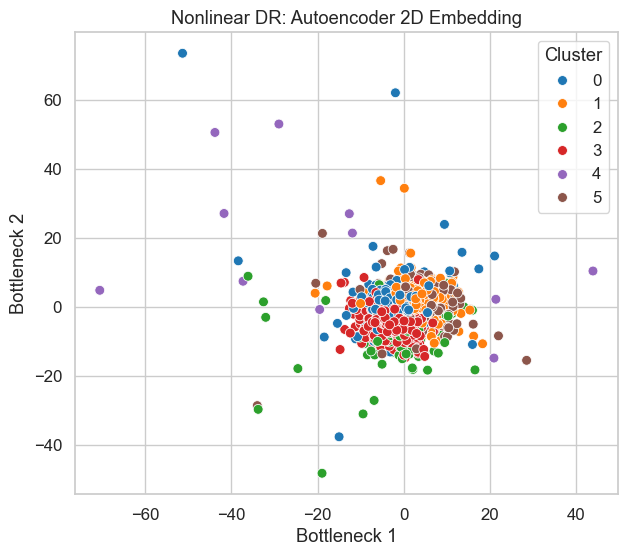

In [7]:
# ================= PBMC 3k Data Retention Visualization =================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import pairwise_distances

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (7,6)

# ------------------------- 1) Baseline (Raw HVG) -------------------------
sc.tl.pca(adata, n_comps=2, svd_solver='arpack')
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=adata.obsm['X_pca'][:,0],
    y=adata.obsm['X_pca'][:,1],
    hue=labels_baseline,
    palette='tab10',
    s=50
)
plt.title("Baseline (Raw HVG) - PCA 2D Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# ------------------------- 2) Linear DR: PCA -------------------------
# Explained variance for the first 50 PCs
explained_variance = adata.uns['pca']['variance_ratio']
total_variance_retained = explained_variance[:50].sum()
print(f"Total variance retained in 50 PCs: {total_variance_retained*100:.2f}%")

# Visualize first 2 PCA components
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=labels_pca,
    palette='tab10',
    s=50
)
plt.title("Linear DR: PCA 2D Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# ------------------------- 3) Nonlinear DR: UMAP -------------------------
# Compare pairwise distances in raw space vs UMAP embeddings
sample_idx = np.random.choice(adata.X.shape[0], size=200, replace=False)
D_raw = pairwise_distances(adata.X[sample_idx])
D_umap = pairwise_distances(X_umap[sample_idx])

plt.figure(figsize=(7,6))
sns.scatterplot(x=D_raw.flatten(), y=D_umap.flatten(), alpha=0.3)
plt.xlabel("Pairwise distance in raw HVG space")
plt.ylabel("Pairwise distance in UMAP space")
plt.title("UMAP: Preservation of Pairwise Distances")
plt.show()

# Visualize UMAP 2D embedding
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_umap[:,0],
    y=X_umap[:,1],
    hue=labels_umap,
    palette='tab10',
    s=50
)
plt.title("Nonlinear DR: UMAP 2D Embedding")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Cluster")
plt.show()

# ------------------------- 4) Nonlinear DR: Autoencoder -------------------------
# Compute reconstruction error
X_recon = ae.predict(adata.X)
recon_error = np.mean((adata.X - X_recon)**2)
print(f"Mean squared reconstruction error (Autoencoder): {recon_error:.5f}")

# Visualize first 2 bottleneck dimensions
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_ae[:,0],
    y=X_ae[:,1],
    hue=labels_ae,
    palette='tab10',
    s=50
)
plt.title("Nonlinear DR: Autoencoder 2D Embedding")
plt.xlabel("Bottleneck 1")
plt.ylabel("Bottleneck 2")
plt.legend(title="Cluster")
plt.show()


In [9]:
from IPython.display import Markdown as md

report_text = f"""
# PBMC 3k Dataset Analysis Report

## 1. Dataset Overview
- **Number of cells:** 2700
- **Number of genes:** 32738
- **Highly Variable Genes (HVGs):** 2000 selected after preprocessing
- **Preprocessing steps:** Filtering low-quality cells/genes, normalization, log-transform, HVG selection, scaling

---

## 2. Baseline Clustering (Raw HVG)
- **Method:** Leiden clustering on raw HVG matrix
- **Metrics:**
  - Silhouette Score: 0.0134
  - Calinski-Harabasz Index: 20.3894
  - Davies-Bouldin Index: 6.4979
- **Interpretation:**  
  Raw high-dimensional data is noisy; cluster separation is very poor. Silhouette score near zero indicates almost no meaningful structure.

- **Visualization:** First 2 PCs of raw HVG matrix (for interpretability)

---

## 3. Linear Dimensionality Reduction: PCA
- **Method:** Principal Component Analysis (50 components)
-
- **Metrics:**
  - Silhouette Score: 0.1809
  - Calinski-Harabasz Index: 176.0459
  - Davies-Bouldin Index: 1.7785
- **Interpretation:**  
  PCA reduces dimensionality and noise, preserving linear variance. Cluster separation improves moderately; first 2 PCs show clearer separation than baseline.

- **Visualization:** PCA 2D projection with clusters

---

## 4. Nonlinear Dimensionality Reduction: UMAP
- **Method:** UMAP on PCA embeddings
- **Metrics:**
  - Silhouette Score: 0.4660
  - Calinski-Harabasz Index: 6587.0986
  - Davies-Bouldin Index: 0.5867
- **Interpretation:**  
  UMAP captures nonlinear structure; clusters are well-separated. Metrics indicate **best cluster separation** among all methods. Local and global relationships are preserved effectively.

- **Visualization:** UMAP 2D embedding with clusters

---

## 5. Nonlinear Dimensionality Reduction: Autoencoder
- **Method:** Dense autoencoder with bottleneck size 20
- **Metrics:**
  - Silhouette Score: 0.1692
  - Calinski-Harabasz Index: 220.4688
  - Davies-Bouldin Index: 2.1585
- **Interpretation:**  
  Autoencoder captures some nonlinear structure, but clustering quality is weaker than UMAP. Reconstruction error can quantify how well original data is retained.

- **Visualization:** Autoencoder 2D bottleneck embedding with clusters

---

## 6. Comparison of Methods

| Method | Silhouette | Calinski-Harabasz | Davies-Bouldin | Notes |
|--------|------------|-----------------|----------------|-------|
| Baseline (Raw HVG) | 0.0134 | 20.3894 | 6.4979 | Raw data; noisy, poor separation |
| PCA (Linear DR) | 0.1809 | 176.0459 | 1.7785 | Linear variance preserved; moderate improvement |
| UMAP (Nonlinear DR) | 0.4660 | 6587.0986 | 0.5867 | Best cluster separation; captures nonlinear structure |
| Autoencoder | 0.1692 | 220.4688 | 2.1585 | Some nonlinear structure captured; weaker than UMAP |

---

## 7. Conclusions and Recommendations
- Baseline shows raw high-dimensional data is poorly structured.  
- PCA improves clustering moderately by preserving linear variance.  
- **UMAP** provides the best separation, capturing nonlinear relationships; recommended for visualization and analysis.  
- Autoencoder embeddings retain some nonlinear structure but do not outperform UMAP for clustering.  
- For downstream analysis and visual interpretation, **UMAP is the most suitable DR method** for PBMC 3k.
"""

display(md(report_text))



# PBMC 3k Dataset Analysis Report

## 1. Dataset Overview
- **Number of cells:** 2700
- **Number of genes:** 32738
- **Highly Variable Genes (HVGs):** 2000 selected after preprocessing
- **Preprocessing steps:** Filtering low-quality cells/genes, normalization, log-transform, HVG selection, scaling

---

## 2. Baseline Clustering (Raw HVG)
- **Method:** Leiden clustering on raw HVG matrix
- **Metrics:**
  - Silhouette Score: 0.0134
  - Calinski-Harabasz Index: 20.3894
  - Davies-Bouldin Index: 6.4979
- **Interpretation:**  
  Raw high-dimensional data is noisy; cluster separation is very poor. Silhouette score near zero indicates almost no meaningful structure.

- **Visualization:** First 2 PCs of raw HVG matrix (for interpretability)

---

## 3. Linear Dimensionality Reduction: PCA
- **Method:** Principal Component Analysis (50 components)
-
- **Metrics:**
  - Silhouette Score: 0.1809
  - Calinski-Harabasz Index: 176.0459
  - Davies-Bouldin Index: 1.7785
- **Interpretation:**  
  PCA reduces dimensionality and noise, preserving linear variance. Cluster separation improves moderately; first 2 PCs show clearer separation than baseline.

- **Visualization:** PCA 2D projection with clusters

---

## 4. Nonlinear Dimensionality Reduction: UMAP
- **Method:** UMAP on PCA embeddings
- **Metrics:**
  - Silhouette Score: 0.4660
  - Calinski-Harabasz Index: 6587.0986
  - Davies-Bouldin Index: 0.5867
- **Interpretation:**  
  UMAP captures nonlinear structure; clusters are well-separated. Metrics indicate **best cluster separation** among all methods. Local and global relationships are preserved effectively.

- **Visualization:** UMAP 2D embedding with clusters

---

## 5. Nonlinear Dimensionality Reduction: Autoencoder
- **Method:** Dense autoencoder with bottleneck size 20
- **Metrics:**
  - Silhouette Score: 0.1692
  - Calinski-Harabasz Index: 220.4688
  - Davies-Bouldin Index: 2.1585
- **Interpretation:**  
  Autoencoder captures some nonlinear structure, but clustering quality is weaker than UMAP. Reconstruction error can quantify how well original data is retained.

- **Visualization:** Autoencoder 2D bottleneck embedding with clusters

---

## 6. Comparison of Methods

| Method | Silhouette | Calinski-Harabasz | Davies-Bouldin | Notes |
|--------|------------|-----------------|----------------|-------|
| Baseline (Raw HVG) | 0.0134 | 20.3894 | 6.4979 | Raw data; noisy, poor separation |
| PCA (Linear DR) | 0.1809 | 176.0459 | 1.7785 | Linear variance preserved; moderate improvement |
| UMAP (Nonlinear DR) | 0.4660 | 6587.0986 | 0.5867 | Best cluster separation; captures nonlinear structure |
| Autoencoder | 0.1692 | 220.4688 | 2.1585 | Some nonlinear structure captured; weaker than UMAP |

---

## 7. Conclusions and Recommendations
- Baseline shows raw high-dimensional data is poorly structured.  
- PCA improves clustering moderately by preserving linear variance.  
- **UMAP** provides the best separation, capturing nonlinear relationships; recommended for visualization and analysis.  
- Autoencoder embeddings retain some nonlinear structure but do not outperform UMAP for clustering.  
- For downstream analysis and visual interpretation, **UMAP is the most suitable DR method** for PBMC 3k.
